# Data Loading

Note that we will encode a positive review as a 1 and a negative review as a 0.

In [31]:
import os
import pandas as pd
import numpy as np
import math

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
TRAIN_PATH = 'aclImdb/train'
TEST_PATH = 'aclImdb/test'

In [3]:
def data_read(path, train_or_test, pos_or_neg):
    reviews, labels = [], []
    
    for filename in os.listdir(path + '/' + pos_or_neg):
        with open(path + '/' + pos_or_neg + '/' + filename) as f:
            reviews.append(f.read())
        if pos_or_neg == 'pos':
            label = 1
        else:
            label = 0
        labels.append(label)
    
    return reviews, labels

In [4]:
pos_results = data_read(TRAIN_PATH, 'train', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'train', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [5]:
train_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [6]:
train_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [7]:
pos_results = data_read(TRAIN_PATH, 'test', 'pos')
reviews = pos_results[0]
labels = pos_results[1]

neg_results = data_read(TRAIN_PATH, 'test', 'neg')
reviews += neg_results[0]
labels += neg_results[1]

In [8]:
test_df = pd.DataFrame({'reviews': reviews, 'y': labels})

In [9]:
test_df.head()

,reviews,y
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [10]:
test_df.tail()

,reviews,y
24995,"My comments may be a bit of a spoiler, for wha...",0
24996,"The ""saucy"" misadventures of four au pairs who...",0
24997,"Oh, those Italians! Assuming that movies about...",0
24998,Eight academy nominations? It's beyond belief....,0
24999,"Not that I dislike childrens movies, but this ...",0


# Pre-Processing

In [11]:
MAX_LENGTH = 15

UNK_token = 0
PAD_token = 1
SOS_token = 2
EOS_token = 3

In [12]:
class Voc(Dataset):
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4 # include the ones above

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word.lower())

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # remove words that appear less frequently
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', 
                           EOS_token: 'EOS', UNK_token: 'UNK'}
        self.num_words = 4
        for word in keep_words:
            self.add_word(word)

# takes string sentence and returns sentence of word indices
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split()] + [EOS_token]

In [13]:
class ReviewDataset():
    def __init__(self, df):
        """Bad coding practice to use the globals but it will work for now"""
        self.reviews = df
        self.text = df['reviews']
        self.rating = df['y']
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return (self.text[idx], self.rating[idx])

In [14]:
reviews = Voc('reviews')

In [15]:
for review in train_df['reviews']:
    reviews.add_sentence(review)

In [16]:
train_ds = ReviewDataset(train_df)
test_ds = ReviewDataset(test_df)

In [17]:
indexesFromSentence(reviews, 'hello world')

[22454, 562, 3]

Write out reviews to pickle object for later prediction

In [18]:
import pickle

pickle.dump(reviews, open('./model/reviews.pkl', 'wb'))

In [19]:
train_dataloader = DataLoader(train_ds,
                              batch_size=1000,
                              shuffle=True, 
                              num_workers=4)

test_dataloader = DataLoader(test_ds,
                             batch_size=1000,
                             shuffle=True,
                             num_workers=4)

# Modeling

The Han model is going to fit a GRU, and for each word i in the sequence, we will collect the hidden layer $h_{i}$. Then for the attention model we have the following algorithm, for word $w_{t}$ in sentence of length T.

Step 3)

$u_{i} = tanh(W_{w}h_{i} + b_{i})$

Step 4)

$\alpha_{i} = \frac{exp(u_{i}^{T}u_{w})}{\Sigma_{i}exp(u_{i}^{T}u_{w})}$

Step 5)

$s = \Sigma_{i} \alpha_{i}h_{i}$










.

s is then input into a neural network for regression or classification.

In [23]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=60, hidden_size=15, num_layers=1, dropout=0.1):
        super(HAN, self).__init__()
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True,
                              dropout=(0 if num_layers==1 else dropout),
                              bidirectional=True)

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(2*hidden_size, 100)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(100, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.fc3 = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # convert word indices to embeddings
        embedded = self.embedding(input_seq)
        
        # pass embeddings through GRU
        # all_layers is shape batch_size x max(sentence_length) x hidden_size*2
        all_layers, final = self.gru(embedded, hidden)

        # pass the hidden layers through linear layer
        # each word of each document will now be a length 100 tensor
        u = self.tanh( self.fc1(all_layers) )
        
        # map the length 100 tensor to a scalar representing importance
        # take the softmax to get the word importance WRT the document
        alpha = self.softmax( self.fc2(u) )
        
        # take sum of hidden layers for each sentence weighted by the alphas 
        s = (all_layers*alpha).sum(dim=1)
        
        # take the linear combination of hidden layers and 
        # plug into Linear Layer and Sigmoid to get probability
#         s = self.sigmoid( self.fc3(s) )
        s = self.fc3(s)
        
        return s.squeeze(), alpha.squeeze() # will add alphas for visualization later

In [24]:
def train(model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        losses = []
        
        for i, mails in enumerate(train_dataloader):
            # read in values from dataloader
            x = mails[0]
            y = mails[1]

            # index sentence and get lengths
            x = [sen.split() for sen in x]
            lengths = [len(sen) for sen in x]
            x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

            # create padded matrix
            batch_size = len(y)
            max_length = max(lengths)
            padded_x = np.ones((batch_size, max_length))*PAD_token
            for idx, x_len in enumerate(lengths):
                sequence = x[idx]
                padded_x[idx, 0:x_len] = sequence[:x_len]

            x = torch.Tensor(padded_x).long()
            y_hat, alpha = han(x, lengths)
            optimizer.zero_grad()
            
            loss = criterion(y_hat, y.float())
            loss.backward()
            optimizer.step()
            losses += [loss.item()]
            
        print(f'Train Loss after {epoch+1} epochs: {np.mean(losses)}')
        if epoch % 5 == 4:
            test(model)


def test(model):
    model.eval()
    losses, correct, total = [], 0, 0
    for i, mails in enumerate(test_dataloader):
        # read in values from dataloader
        x = mails[0]
        y = mails[1]

        # index sentence and get lengths
        x = [sen.split() for sen in x]
        lengths = [len(sen) for sen in x]
        x = [[reviews.word2index.get(word, UNK_token) for word in sentence] for sentence in x]

        # create padded matrix
        batch_size = len(y)
        max_length = max(lengths)
        
        padded_x = np.ones((batch_size, max_length))*PAD_token
        for idx, x_len in enumerate(lengths):
            sequence = x[idx]
            padded_x[idx, 0:x_len] = sequence[:x_len]

        x = torch.Tensor(padded_x).long()
        y_hat, _ = han(x, lengths)

        # cross-entropy
        loss = criterion(y_hat, y.float())
        losses += [loss.item()]
        
        # accuracy
        # print(y_hat == y)
        # correct += sum( y_hat == y )
        # total += y.shape.squeeze().tolist()
        
    print(f'Test Loss: {np.mean(losses)}\n')
    # print(f'Test Accuracy: {correct / total}')

# Training

In [25]:
V = len(reviews.index2word)
han = HAN(hidden_size=40, vocab_size=V, embedding_dim=50)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(han.parameters(), lr=0.01)

train(han, 20)

Train Loss after 1 epochs: 0.678569655418396
Train Loss after 2 epochs: 0.522399514913559
Train Loss after 3 epochs: 0.34435847103595735
Train Loss after 4 epochs: 0.16044421523809432
Train Loss after 5 epochs: 0.061335157603025436
Test Loss: 0.0261311249434948

Train Loss after 6 epochs: 0.0191841222345829
Train Loss after 7 epochs: 0.006571692358702422
Train Loss after 8 epochs: 0.003411653712391853
Train Loss after 9 epochs: 0.0021326040220446883
Train Loss after 10 epochs: 0.0020969630498439075
Test Loss: 0.0016086027468554677

Train Loss after 11 epochs: 0.004618597531225533
Train Loss after 12 epochs: 0.004192256764508784
Train Loss after 13 epochs: 0.002409373081754893
Train Loss after 14 epochs: 0.001007323528174311
Train Loss after 15 epochs: 0.0007438638899475336
Test Loss: 0.00038465476303827016

Train Loss after 16 epochs: 0.004079316125717014
Train Loss after 17 epochs: 0.0037302453303709624
Train Loss after 18 epochs: 0.0019192558259237557
Train Loss after 19 epochs: 0.00

In [26]:
torch.save(han.state_dict(), '/Users/jon_ross/Desktop/HAN_lower.pt')

TODO: Resume here by loading the model

# Visualize Attention

In [36]:
import matplotlib.pyplot as plt
from matplotlib import transforms


def sigmoid(x): return 1 / (1 + math.exp(-x))

def text_color(x, y, strings, colors, ax=None, **kw): 
    """x and y will be equal to 0
    strings is a list of words
    colors is a list of numbers [0,1] 
    where 1 represents the most important word"""
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    # horizontal version
    for s, c in zip(strings, colors):
        text = ax.text(x, y, s + " ", color=(0.69-0.69*c,0.69-0.69*c,1), transform=t, **kw)
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(
            text.get_transform(), x=ex.width, units='dots')
        

def visualize_attention(sentence):
    sentence_tensor = torch.Tensor( [reviews.word2index[word] for word in sentence.split()] ).long()
    sentence_tensor = sentence_tensor.unsqueeze(dim=0)
    
    p, alpha = han( sentence_tensor, [len(sentence.split())] )
    print(f'Probability of positive review: { sigmoid(p) }')
    
    text_color(0, 0, sentence.split(), alpha.tolist())
    plt.axis('off')

TODO: Unseen words are breaking the visualize function and I think it's because of the casing issues

Probability of positive review: 0.02744986983283157


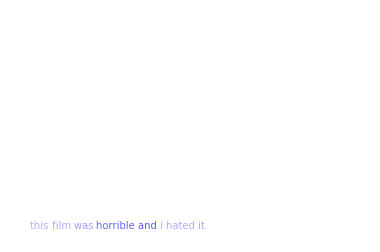

In [37]:
visualize_attention('this film was horrible and i hated it')

Probability of positive review: 0.9999045230107327


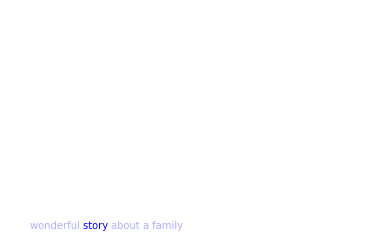

In [38]:
visualize_attention('wonderful story about a family')

Probability of positive review: 0.9998630936055926


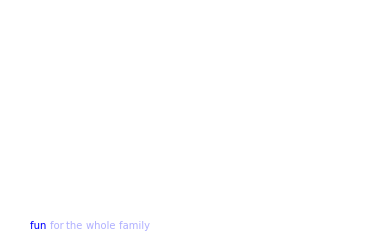

In [39]:
visualize_attention('fun for the whole family')

Probability of positive review: 0.877300941328807


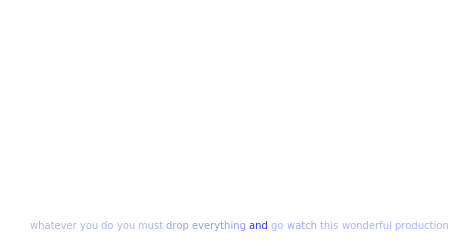

In [40]:
visualize_attention('whatever you do you must drop everything and go watch this wonderful production')

Probability of positive review: 0.021357637542321062


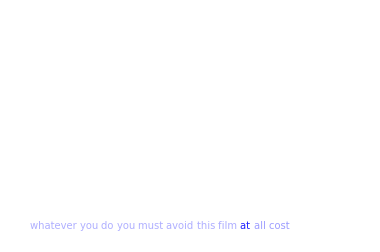

In [41]:
visualize_attention('whatever you do you must avoid this film at all cost')